# Static plotting for `spatialdata` 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

In [14]:
import spatialdata as sd
import spatialdata_plot
import matplotlib.pyplot as plt  # for multi-panel plots later

sdata_merfish = sd.read_zarr("../data/merfish.zarr")

In particular, the library exposes the following funcitons:
- [`Spatialdata.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images)
- [`Spatialdata.pl.render_labels()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels)
- [`Spatialdata.pl.render_points()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_points)
- [`Spatialdata.pl.render_shapes()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes)
- [`Spatialdata.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show)

We can chain the 4 `render_xxx` functions to gradually build up a figure, with a final call to `show` to then actually render out the function. In the following sections we will explore these functions further.


## Overview
- [Simple function calls](#simple-viz)
- [Stacking function calls](#stacked-viz)

## Simple function calls <a id="simple-viz"></a>
Let's first focus on the [MERFISH](https://vizgen.com/technology/) data from the previous notebook. As we can see below, it contains slots for `Images`, `Points`, `Shapes`, and `Tables`.

In [8]:
sdata_merfish

SpatialData object, with associated Zarr store: /Users/ttreis/Documents/GitHub/spatialdata-workshops/data/merfish.zarr
├── Images
│     └── 'rasterized': DataArray[cyx] (1, 522, 575)
├── Points
│     └── 'single_molecule': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'anatomical': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'cells': GeoDataFrame shape: (2389, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2389, 268)
with coordinate systems:
    ▸ 'global', with elements:
        rasterized (Images), single_molecule (Points), anatomical (Shapes), cells (Shapes)

Let's first visualise the individual contained modalities separately. 

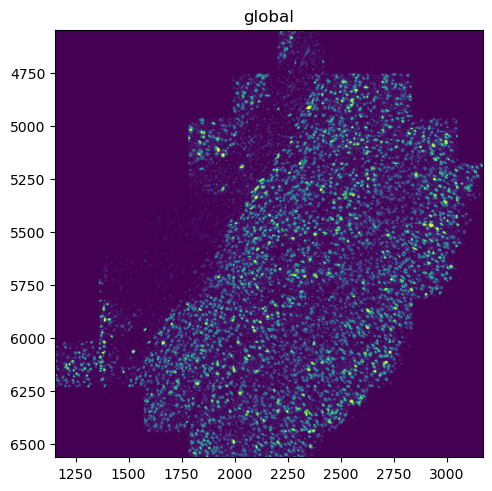

In [9]:
sdata_merfish.pl.render_images().pl.show()

/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


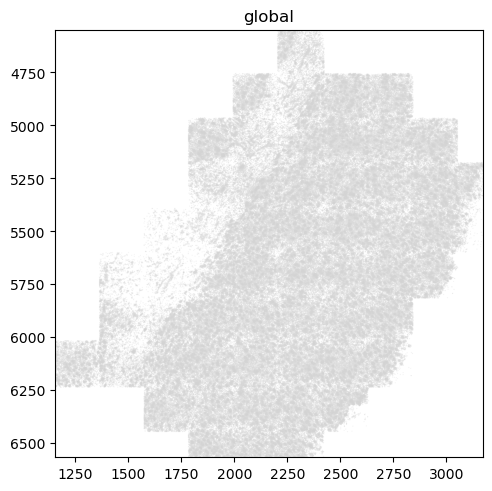

In [10]:
sdata_merfish.pl.render_points().pl.show()

INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          


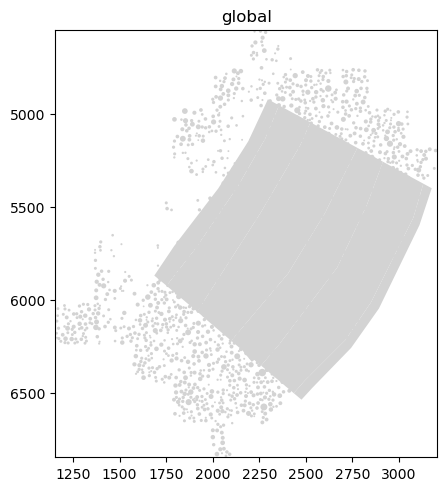

In [12]:
sdata_merfish.pl.render_shapes().pl.show()  # visualises the two shapes on top of each other since they exist in the same coordinate system "global"

INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          


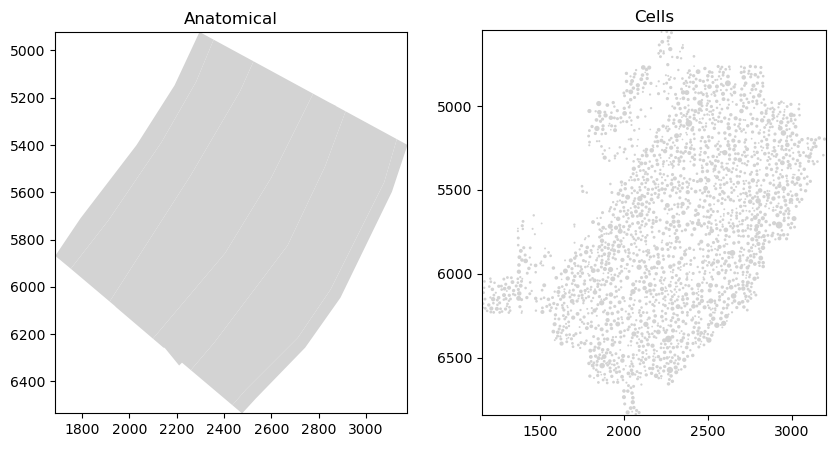

In [24]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))

sdata_merfish.pl.render_shapes(element="anatomical").pl.show(ax=axs[0], title="Anatomical")
sdata_merfish.pl.render_shapes(element="cells").pl.show(ax=axs[1], title="Cells")

## Stacked function calls <a id="stacked-viz"></a>

Very similar to other matplotlib-based tools, we can also add multiple elements to the same `ax` object here. If we chain the function calls and the elements exist within the same coordinate system, this happens automatically. Based on the name of the `Shapes` object, we can already assume that the "anatomical" element contains some anatomical annotations. We will modify some visual parameters to make the individual shapes more easily.

INFO     Using matplotlib                                                                                          


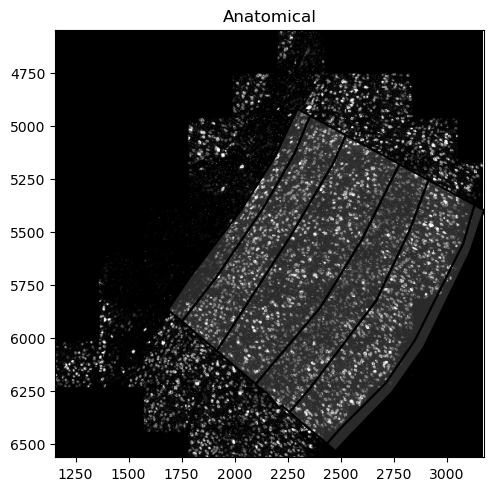

In [57]:
(
    sdata_merfish
    .pl.render_images(cmap="grey")
    .pl.render_shapes(element="cells", fill_alpha=1, color="Lamp5")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Anatomical")
)

We can appreciate, comparing with the previous plots, that the two elements are correctly overlayed. We can use further information contained in the objects to further improve this information. The contained table is an `AnnData` object. Let's inspect it.

In [58]:
sdata_merfish.tables["table"]

AnnData object with n_obs × n_vars = 2389 × 268
    obs: 'cell_id', 'region'
    uns: 'spatialdata_attrs'

The `Anndata.X` matrix itself contains the gene expression of each individual cell:

In [60]:
sdata_merfish.tables["table"].to_df()

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Unc5b,Unc5d,Ust,Vip,Vipr2,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,328,0,0,1,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,9,1,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,14,0,0,3,0,0,0
4,0,0,0,1,0,0,0,2,0,0,...,0,0,1,4,0,0,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,0,0,0,0,3,1,0,0,0,0,...,0,1,2,2,0,0,3,2,0,0
2395,0,0,0,0,6,1,0,1,0,0,...,1,2,0,6,1,0,1,3,1,1
2396,0,1,0,1,3,2,0,3,0,0,...,1,2,2,2,1,0,8,5,0,0
2397,1,0,0,0,0,0,0,2,0,2,...,1,0,2,4,0,0,2,0,0,0


We can use this data to, for example, color a shapes object by its expression:

INFO     Using matplotlib                                                                                          
INFO     Using matplotlib                                                                                          


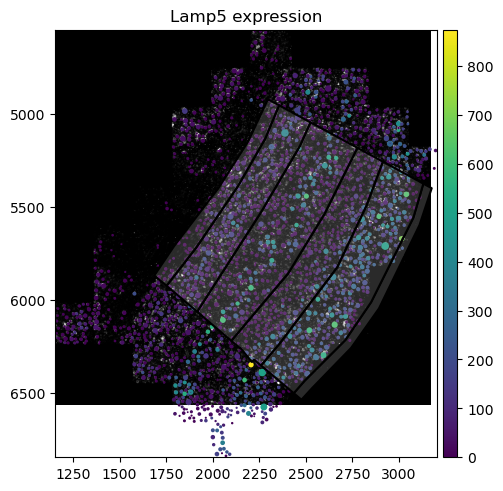

In [68]:
(
    sdata_merfish
    .pl.render_images(cmap="grey")
    .pl.render_shapes(element="cells", fill_alpha=1, color="Lamp5")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Lamp5 expression")
)

Furthermore, the `Points` object "single_molecule" is also associated with metadata, namely the celltype it was annotated to be associated with.

In [64]:
sdata_merfish["single_molecule"].compute() # this is a dask dataframe, so we need to call compute to get the actual data

,x,y,cell_type
0,1278.683956,6020.642260,outside_VISp
1,1326.970330,6023.884788,outside_VISp
2,1292.026844,6059.337093,outside_VISp
3,1300.886241,6097.786264,outside_VISp
4,1232.410068,6102.884182,outside_VISp
...,...,...,...
3714637,3161.427603,5192.594981,outside_VISp
3714638,3099.698528,5221.596008,outside_VISp
3714639,3084.582240,5297.234605,outside_VISp
3714640,3054.192051,5342.142346,VISp_II/III


Similarly, we can use these annotations to color our points:

/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:719: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action

INFO     Using matplotlib                                                                                          


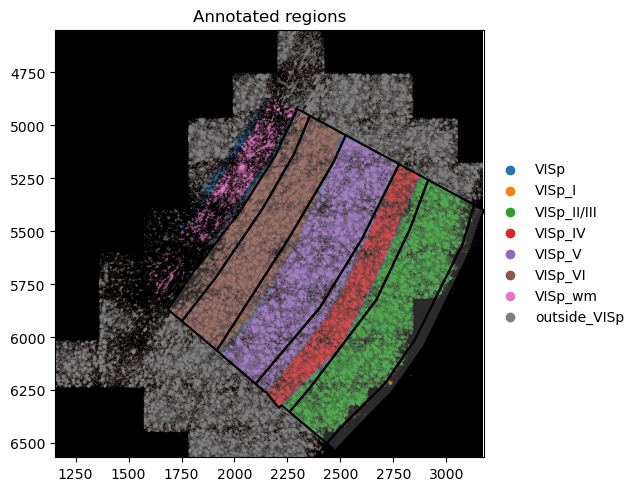

In [70]:
(
    sdata_merfish
    .pl.render_images(cmap="grey")
    .pl.render_points(color="cell_type")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Annotated regions")
)